### Living Arrangements Examples from CPS

September 1, 2020

Attempt at replication of [this](https://www.federalreserve.gov/econres/notes/feds-notes/an-early-evaluation-of-the-effects-of-the-pandemic-on-living-arrangements-and-household-formation-20200807.htm). 

---- 

**Update**: September 17, 2020

The gap between the published results and my local calculations seems to be coming from how headship is defined. In the CPS, the household ID is the person ID of the wife in husband-wife households and the reference person in all other households. In the published data, the head of household is defined using a process that assigns an average headship to each person in the CPS.

Currently trying to implement a new variable in the bd CPS called `HEAD` which is the average headship rate for an individual age 16 or older, based on Paciorek (2013, 2016). 

Also, because the published results are seasonally adjusted and the raw data have a clear seasonal pattern, it would be helpful to give an overview of the seasonal factors. 

In [1]:
import pandas as pd
comp_data = pd.read_csv('fed_hh_example.csv')

import os
os.chdir('/home/brian/Documents/CPS/data/')
os.environ['X13PATH'] = '/home/brian/Documents/econ_data/micro/x13as/'

import re, struct
import numpy as np
from statsmodels.tsa.x13 import x13_arima_analysis

### Aggregate approach

In [97]:
cols = ['QSTNUM', 'AGE', 'YEAR', 'MONTH', 'HHWGT', 'PWSSWGT']

df = pd.concat([pd.read_feather(f'clean/cps{year}.ft', columns=cols)
                  .query('AGE > 15') 
                for year in range(1996, 2021)])

headship_rate = (lambda grp: grp.groupby('QSTNUM').HHWGT.first().sum()
                 / grp.PWSSWGT.sum())

data = (df.groupby(['YEAR', 'MONTH']).apply(headship_rate)).reset_index()
data['DATE'] = pd.to_datetime(dict(year=data.YEAR, month=data.MONTH, day=1))
data = data.set_index('DATE').drop(['YEAR', 'MONTH'], axis=1) * 100

sm = x13_arima_analysis(data[0])

/home/brian/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/x13.py:187: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


### "Average" approach

In [90]:
cols = ['QSTNUM', 'AGE', 'YEAR', 'MONTH', 'PWSSWGT', 'HEAD']

df = pd.concat([pd.read_feather(f'clean/cps{year}.ft', columns=cols)
                  .query('AGE > 15') 
                for year in range(1996, 2021)])

headship_rate = (lambda grp: np.average(grp.HEAD, weights=grp.PWSSWGT))
data = (df.groupby(['YEAR', 'MONTH']).apply(headship_rate)).reset_index()
data['DATE'] = pd.to_datetime(dict(year=data.YEAR, month=data.MONTH, day=1))
data = data.set_index('DATE').drop(['YEAR', 'MONTH'], axis=1) * 100

sm = x13_arima_analysis(data[0])

/home/brian/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/x13.py:187: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


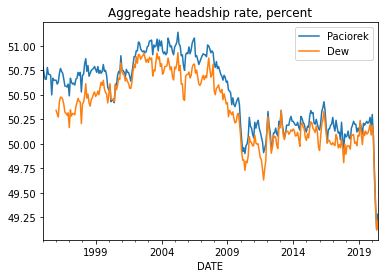

In [98]:
comp_data['DATE'] = pd.to_datetime(comp_data['date'])
comb = (comp_data.set_index('DATE')
                 .join(sm.seasadj)
                 .rename({'headship': 'Paciorek', 'seasadj': 'Dew'}, axis=1))
comb[['Paciorek', 'Dew']].plot(title='Aggregate headship rate, percent');

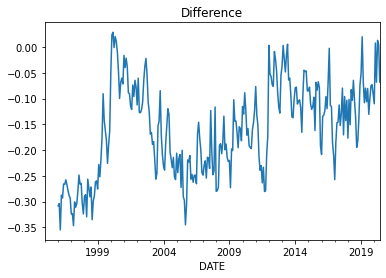

In [99]:
(comb['Dew'] - comb['Paciorek']).plot(title='Difference');

### Average monthly pattern from x13as adjustment

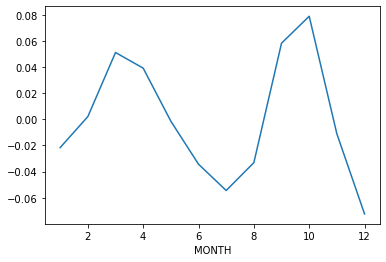

In [126]:
((sm.observed - sm.seasadj).reset_index()
                           .assign(MONTH = lambda x: x.DATE.dt.month)
                           .groupby('MONTH')[0].mean().plot());

# Looking at individual months to figure out difference

### Update: Try taking average of individual "headship rate"

Assign an average headship to each person in the CPS, attempting to replicate Paciorek (2013, 2016).

In [127]:
date = '2020-05-01'
cpsdt = pd.to_datetime(date).strftime('%b%y').lower()
textdt = pd.to_datetime(date).strftime('%B %Y')
print(textdt)

# manually list out the IDs for series of interest 
var_names = ['PWSSWGT', 'QSTNUM', 'PRTAGE', 'PULINENO', 
             'PESPOUSE', 'HURESPLI'] 

dd = '2020_Basic_CPS_Public_Use_Record_Layout_plus_IO_Code_list.txt'
data_dict = open(dd, 'r', encoding='iso-8859-1').read()

p = f'\n({"|".join(var_names)})\s+(\d+)\s+.*?\t+.*?(\d\d*).*?(\d\d+)'

d = {s[0]: [int(s[2])-1, int(s[3]), f'{s[1]}s']
     for s in re.findall(p, data_dict)}

start, end, width = zip(*d.values())
skip = ([f'{s - e}x' for s, e in zip(start, [0] + list(end[:-1]))])
unpack_fmt = ''.join([j for i in zip(skip, width) for j in i])
unpacker = struct.Struct(unpack_fmt).unpack_from    

file = f'{cpsdt}pub.dat'
raw_data = open(file, 'rb').readlines()
data = [[*map(int, unpacker(row))] for row in raw_data]
df = pd.DataFrame(data, columns=d.keys())

hh16 = lambda x: np.where(x.PRTAGE > 15, 1, 0)

hhsize = lambda x: x.groupby('QSTNUM').HH16.transform('sum') # count of age 16+

head1 = (lambda x: (np.where((x.HURESPLI == x.PULINENO) & (x.HHSIZE == 1), 1, # alone (1)
                   np.where((x.HURESPLI == x.PULINENO) & (x.PESPOUSE > 0), 0.5, # spouse1 (0.5)
                   np.where((x.HURESPLI != -1) & (x.HURESPLI == x.PESPOUSE), 0.5, # spouse2 (0.5)
                   np.nan)))))

hhsum = lambda x: x.groupby('QSTNUM').HEAD1.transform('sum')

head2 = (lambda x: (np.where(x.HEAD1.notnull(), np.nan, # already identified
                    np.where(x.HH16 == 0, np.nan, # under 16
                    np.where((x.HHSUM == 1) & (x.HEAD1.isnull()), 0, # living with family (0)
                    1/x.HHSIZE))))) # roommates (1/nr)

head = (lambda x: (np.where(x.HEAD1.notnull(), x.HEAD1, 
                   np.where(x.HEAD2.notnull(), x.HEAD2, np.nan))))

hhsum2 = lambda x: x.groupby('QSTNUM').HEAD.transform('sum')

droplist = ['HH16', 'HHSIZE', 'HEAD1', 'HHSUM', 'HEAD2', 'HURESPLI']

data = df.assign(HH16 = hh16, 
                 HHSIZE = hhsize, 
                 HEAD1 = head1, 
                 HHSUM = hhsum, 
                 HEAD2 = head2, 
                 HEAD = head,
                 HHSUM2 = hhsum2
                ).drop(droplist, axis=1)

d1 = data.query('PRTAGE > 15')
result = np.average(d1.HEAD, weights=d1.PWSSWGT)
print(f' Result (average): {result*100:.2f}',
      '\n\n',f'Result (aggregate): ', comb.loc[date, 'Dew'].round(2),
      '\n\n','Goal: ', comb.loc[date, 'Paciorek'])

incorrect = len(d1[~d1.HHSUM2.between(0.99, 1.01)])
print(f'\n Households with incorrect headship sum: {incorrect}')

May 2020
 Result (average): 49.42 

 Result (aggregate):  49.13 

 Goal:  49.12

 Households with incorrect headship sum: 0


In [79]:
d1

,PRTAGE,PESPOUSE,PULINENO,PWSSWGT,QSTNUM,HEAD
0,72,-1,1,17479947,11906,1.0
1,80,2,1,17816015,11437,0.5
2,80,1,2,18182721,11437,0.5
4,50,-1,1,24249454,24833,0.5
5,85,-1,2,23134010,24833,0.5
...,...,...,...,...,...,...
123350,60,1,2,3273148,21248,0.5
123351,76,2,1,2613962,29576,0.5
123352,77,1,2,2532948,29576,0.5
123357,37,2,1,5620033,36237,0.5


### Living with Family -- Does that match?

In [11]:
(data.query('HWHHWTLN != PULINENO and PERRP in [48, 49, 50, 51, 52, 53]').PWSSWGT.sum() / 
 data.PWSSWGT.sum()) * 100

36.39200602822098

Goal: 20.76

In [12]:
(data.query('PRFAMREL not in [0, 1, 2]').PWCMPWGT.sum() / 
 data.PWCMPWGT.sum()) * 100

18.20508384690031

In [1]:
# Working area

#d1['HHEAD'] = d1.groupby('QSTNUM').HEAD.transform('sum')
#d1[d1.HHEAD < 0.99]
#d1.query('QSTNUM == 37931')


    # More detailed headship indicator for those 16+
    #spcheck = lambda x: 1 if x.HURESPLI.iloc[0] in x.SPOUSE.to_list() else 0
    #dfm['SPCHECK'] = dfm.QSTNUM.map(dfm.groupby('QSTNUM').apply(spcheck).to_dict())
    
    # identify husband-wife household
    #hhcat = lambda x: np.where((x.HRHTYPE.isin([1, 2])) & (x.SPCHECK == 1), 1, 0)

    # identify those age 16 or older
    #hh16 = lambda x: np.where(x.AGE > 15, 1, 0)

    # count of age 16+
    #hhsize = lambda x: x.groupby('QSTNUM').HH16.transform('sum') 

    # from Paciorek (2013, 2016)
    #head = (lambda x: (np.where((x.HURESPLI == x.PULINENO) & (x.HHSIZE == 1), 1, 
    #                   np.where((x.HURESPLI == x.PULINENO) & (x.SPOUSE > 0), 0.5, 
    #                   np.where(x.HURESPLI == x.SPOUSE, 0.5, 
    #                   np.where((x.HHCAT == 1) & (x.HH16 == 1), 0,  
    #                   np.where(x.HH16 == 1, 1/x.HHSIZE, np.nan))))))) 

    #dfm = (dfm.assign(HHCAT=hhcat, HH16=hh16, HHSIZE=hhsize, HEAD=head)
    #          .drop(['HHCAT', 'HH16', 'HHSIZE', 'HURESPLI', 'HRHTYPE'], axis=1))
    
    
    
#sp1 = df[df.PESPOUSE > 0].groupby('QSTNUM').PESPOUSE.max()
#sp1.name = 'SPOUSE1'
#sp2 = df[df.PESPOUSE > 0].groupby('QSTNUM').PESPOUSE.min()
#sp2.name = 'SPOUSE2'
#df = df.merge(sp1.reset_index()).merge(sp2.reset_index())